In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
import missingno as msno
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta,date
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve,accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split,cross_validate,cross_val_score,GroupKFold,KFold,cross_val_predict
from sklearn_extra.cluster import KMedoids
from xgboost import XGBClassifier,plot_importance,plot_tree
from lightgbm import LGBMClassifier,plot_importance,plot_metric,plot_tree
from imblearn.over_sampling import SMOTE

# 모의고사 2회

## 1. 정형 데이터 마이닝

### 1-1. 데이터의 요약값을 보고 데이터의 적합성을 판단하고 데이터를 전처리하시오.

In [103]:
train = pd.read_csv('wa_train.csv')
test = pd.read_csv('wa_test.csv')

In [5]:
train.describe(include=['object'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,56837,56837,56837,56837,56837,56837,56837
unique,3382,34,16,16,16,2,2
top,2015-03-24,Darwin,E,N,S,No,No
freq,29,2478,4417,4933,4266,43198,43436


In [6]:
train.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000
mean,13.196201,23.845697,2.639413,41.070781,15.785738,19.758309,67.076341,50.623115,1017.206059,1014.822230,4.403505,4.485388,17.838799,22.342126
std,6.443974,7.164237,9.473492,13.376601,8.314862,8.534648,19.009876,20.912191,6.971337,6.928297,2.866300,2.711135,6.607925,7.031607
min,-6.700000,4.600000,0.000000,9.000000,2.000000,2.000000,1.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-1.000000,1.700000
25%,8.300000,18.200000,0.000000,31.000000,9.000000,13.000000,55.000000,36.000000,1012.600000,1010.000000,1.000000,2.000000,12.700000,16.900000
50%,12.900000,23.400000,0.000000,39.000000,15.000000,19.000000,68.000000,51.000000,1017.100000,1014.700000,5.000000,5.000000,17.400000,21.900000
75%,18.100000,29.300000,1.000000,48.000000,20.000000,24.000000,81.000000,65.000000,1021.900000,1019.500000,7.000000,7.000000,22.900000,27.600000
max,31.400000,48.100000,367.600000,124.000000,69.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.700000


In [104]:
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Date'] = pd.to_datetime(train['Date'])

In [105]:
test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Date'] = pd.to_datetime(test['Date'])

In [106]:
train['RainTomorrow'] = train['RainTomorrow'].map({'Yes': 1, 'No': 0})
train['RainToday'] = train['RainToday'].map({'Yes': 1, 'No': 0})

test['RainTomorrow'] = test['RainTomorrow'].map({'Yes': 1, 'No': 0})
test['RainToday'] = test['RainToday'].map({'Yes': 1, 'No': 0})

<AxesSubplot:>

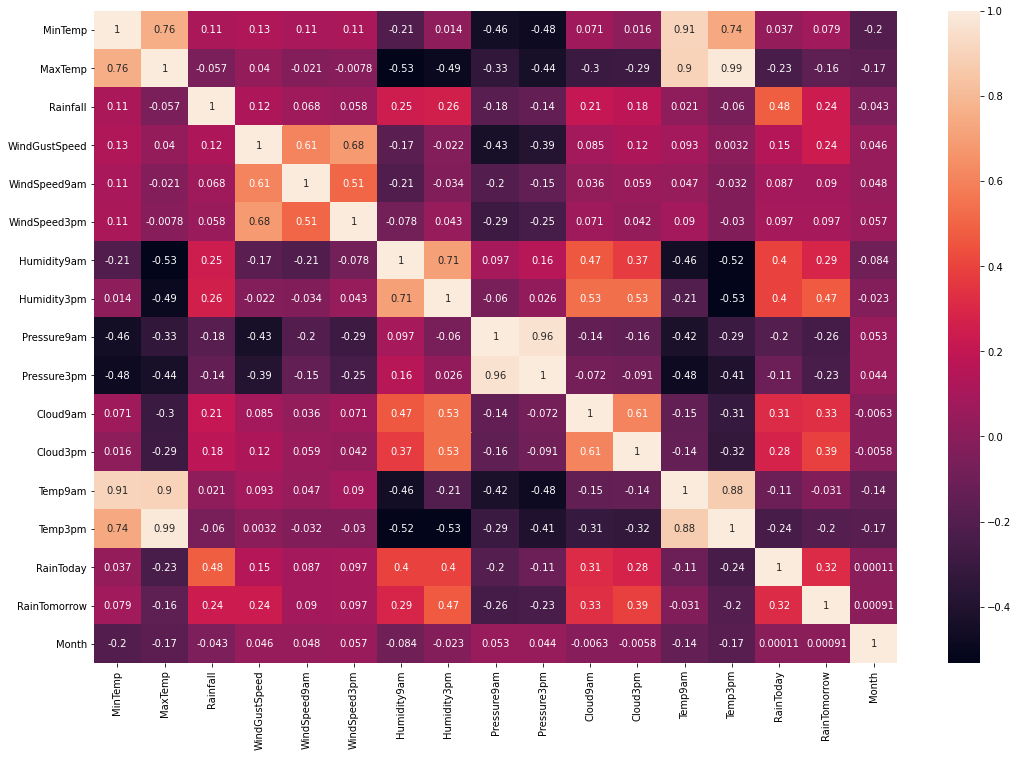

In [66]:
plt.figure(figsize=(18,12))
sns.heatmap(train.corr(),annot=True)

In [75]:
cols = ['Temp9am','Temp3pm','Humidity9am','Date','Pressure3pm']

In [107]:
train.drop(cols,axis = 1,inplace = True)
test.drop(cols, axis = 1,inplace = True)

In [108]:
label = LabelEncoder()

In [109]:
for col in train.columns :
    if train[col].dtypes == 'object' :
        train[col] = label.fit_transform(train[col])

In [110]:
for col in test.columns :
    if test[col].dtypes == 'object' :
        test[col] = label.fit_transform(test[col])

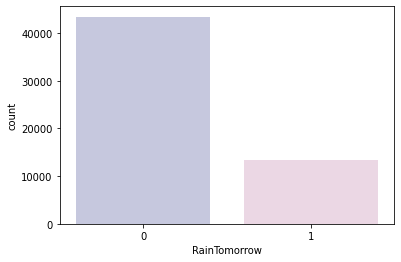

0    0.76422
1    0.23578
Name: RainTomorrow, dtype: float64

In [111]:
cols =  ["#C2C4E2","#EED4E5"]
sns.countplot(x = train['RainTomorrow'],palette=cols)
plt.show()
train['RainTomorrow'].value_counts(normalize= True)

- 불균형 분포이므로 SMOTE를 통해 균형있게 만들것

In [117]:
y = train['RainTomorrow']
train.drop(['RainTomorrow'],axis = 1,inplace = True)

In [114]:
smote = SMOTE(random_state=42)

In [118]:
smote = SMOTE(random_state=42)
train_over, y_over = smote.fit_sample(train,y)

<AxesSubplot:>

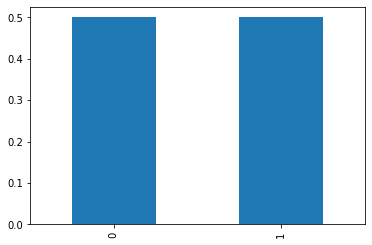

In [123]:
y_over.value_counts(normalize = True).plot.bar()

- 몇몇 변수들 이상치가 큰게 있으므로 이상치 최소화해주는 RobustScaler 사용

In [124]:
robust = RobustScaler()

In [125]:
y_test = test['RainTomorrow']
test.drop(['RainTomorrow'],axis = 1,inplace = True)

In [126]:
train = pd.DataFrame(robust.fit_transform(train_over),columns=train.columns)
test = pd.DataFrame(robust.fit_transform(test),columns=test.columns)

In [127]:
train.shape

(86872, 16)

In [128]:
test.shape

(14208, 16)

### 1-2. 예측을 위한 train / test set 구축방법론들을 설명하고 적합한 방법을 선택하고 데이터를 분할하시오.
- train test 분할 말고 교차검증기법

- 위 Smote를 통해 불균형 분포도를 해결했으니 가장 보편적인 KFOLD를 통해 교차검증을 실시할 것이다.

- StratifiedKFold는 target값의 개수를 동일하게 배정하여 KFold의 target 불균형을 막아준다.

In [130]:
kfold = KFold(n_splits=5,shuffle=True, random_state=123)

### 1-3. RandomForest와 LightGBM의 장단점을 설명하고 각 모형을 활용하여 test 데이터에 대한 예측값을 각각 csv로 만드시오.(코드는 주석처리)

In [214]:
lgbm = LGBMClassifier(random_state=123, n_jobs=-1, learning_rate=0.08, n_estimators=1000,max_depth=-1)
lgbm_pred = np.zeros((test.shape[0]))

i = 0
for tr, val in kfold.split(train,y_over) :
    i += 1
    X_train,y_train = train.iloc[tr],y_over.iloc[tr]
    X_val,y_val = train.iloc[val],y_over.iloc[val]
    
    lgbm.fit(X_train,y_train)
    pred = lgbm.predict(X_val)
    
    print("KFold{}의 Accuracy : {}\n".format(i,accuracy_score(y_val,pred)))
    sub_pred = lgbm.predict_proba(test)[:,1] / 5
    lgbm_pred += sub_pred

KFold1의 Accuracy : 0.904978417266187

KFold2의 Accuracy : 0.9102158273381294

KFold3의 Accuracy : 0.9077356970185334

KFold4의 Accuracy : 0.9083688269828479

KFold5의 Accuracy : 0.9015195119143548



In [ ]:
### pd.DataFrame((lgbm_pred > 0.5).astype('int64'),columns=['RainTommorw']).to_csv("LGBM.csv",index = False)

 - 메모리 사용량도 상대적으로 적고 Category형 Feature 자동 변환과 최적 분할을 해주는 장점이 있으나 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다는 단점이 있다.

In [233]:
rf = RandomForestClassifier(random_state = 123, n_jobs=-1, n_estimators=100)
rf_pred = np.zeros((test.shape[0]))

In [234]:
i = 0
for tr, val in kfold.split(train,y_over) :
    i += 1
    X_train,y_train = train.iloc[tr],y_over.iloc[tr]
    X_val,y_val = train.iloc[val],y_over.iloc[val]
    
    rf.fit(X_train,y_train)
    pred = rf.predict(X_val)
    
    print("KFold{}의 Accuracy : {}\n".format(i,accuracy_score(y_val,pred)))
    sub_pred = rf.predict_proba(test)[:,1] / 5
    rf_pred += sub_pred

KFold1의 Accuracy : 0.9034820143884892

KFold2의 Accuracy : 0.9089496402877698

KFold3의 Accuracy : 0.9075054679406009

KFold4의 Accuracy : 0.9097502014504432

KFold5의 Accuracy : 0.9017497409922873



- 룰이 매우 명호가하고 시각화가 가능하다. 또한, 결정트리로서 쉽고 직관적인 장점을 그대로 살리고 있으나 튜닝을 위한 많은 시간이 소모된다는 단점이 있다.

In [ ]:
### pd.DataFrame((rf_pred>0.5).astype('int64'),columns=['RainTommorow']).to_csv("RF.csv",index = False)

### 1-4. 생성된 모형들의 성과분석을 실시하고 정확도를 비교하고 설명하시오. 또한 Roc-curve를 그리고 AUC 값을 산출하시오.

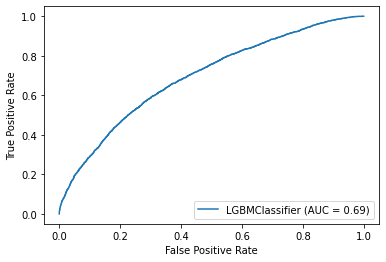

In [240]:
plot_roc_curve(lgbm,test,y_test)

In [242]:
from sklearn.metrics import auc

In [245]:
auc(y_test,lgbm_pred)

0.9865338614334088

In [246]:
auc(y_test,rf_pred)

0.87

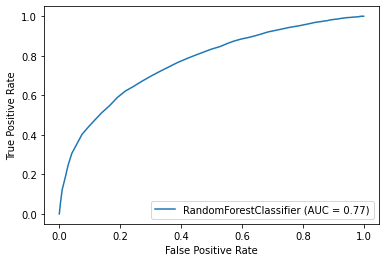

In [241]:
plot_roc_curve(rf,test,y_test)

***
## 2. 연관분석

### 2-1. 연관분석의 측도의 종류와 의미를 설명하고 연관분석의 장단점을 서술하시오.

- 지지도 : 전체 거래 중 항목 A와 항목 B를 동시에 포함하는 거래비율을 의미한다.
- 신뢰도 : 항목 A를 포함한 거래 중에서 항목 A와 항목 B가 같이 포함될 확률으로 연관성의 정도를 파악할 수 있다.
- 향상도 : A가 주어지지 않았을 때의 품목 B의 확률에 비해 A가 주어졌을 때의 품목 B의 증가 비율. 품목A와 품목B가 구매가 서로 관련이 없는 경우에 향상도는 1이 된다. 1이라면 우연적인 경우로, x와 y의 관계가 독립이지만, 1보다 크거나 작다면 우연이 아닌 필연적인 관계에 있음.


### 장단점
장점
- 탐색적인 기법
- 강력한 비목적성 분석기법 : 목적변수가 없으므로 유용하게 활용
- 사용이 편리한 분석 데이터의 형태
- 계산의 용이성

단점 
- 상당한 수의 계산 과정(유사한 품목을 한 범주로 일반화(이러면 요인이나 PCA로 묶을 수 있을 것 같다는 생각이 든다.)
- 적절한 품목의 결정 : 너무 세분화 -> 의미 없는 분석이 될 수도 있다.
- 품목의 비율차이 : 거래량이 적은 품목은 거래수가 적을 것이고 당연히 규칙 발견 시 제외하기 쉽다.

In [247]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

### 2-2. 고객(cust_id)별로 구매한 품목 리스트를 기준으로 연관분석을 실시하시오.(최소 지지도 0.05 이상)

In [362]:
df = pd.read_table('dataTransactions.tab',encoding = 'cp949')

In [363]:
df['datetime'] = [df['datetime'][i].split(' ')[0] for i in range(len(df))]

In [365]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [366]:
df.describe(include='object')

,store,brand,corner
count,19125,19125,19125
unique,4,1191,26
top,신촌점,식품,일반식품
freq,6110,5267,5267


In [352]:
range_value = df_tmp['cust'].nunique()+1

In [369]:
association_df = df.groupby(['custid','datetime'])['corner'].agg(lambda x : list(x)).reset_index()

In [376]:
association_df['corners'] = [list(set(association_df['corner'][i])) for i in range(len(association_df))]

In [378]:
te = TransactionEncoder()
te_ary = te.fit(association_df['corners']).transform(association_df['corners'])
df = pd.DataFrame(te_ary, columns=te.columns_)

In [402]:
association = apriori(df,min_support=0.01, use_colnames=True)

In [410]:
association

,support,itemsets
0,0.021745,(가전)
1,0.018736,(기타)
2,0.060674,(니트단품)
3,0.016989,(도자기크리스탈)
4,0.012620,(디자이너부띠끄)
5,0.044268,(문화완구)
6,0.059509,(섬유)
7,0.027182,(수입명품)
8,0.083681,(스포츠)
9,0.034074,(엘레강스캐주얼)


In [418]:
association['length'] = association['itemsets'].apply(lambda x : len(x))


In [422]:
association.loc[association['length']>1].sort_values(by='support',ascending = False)

,support,itemsets,length
35,0.033201,"(일반식품, 화장품)",2
32,0.024075,"(일반식품, 유아동복)",2
27,0.018056,"(일반식품, 스포츠)",2
34,0.015921,"(일반식품, 피혁)",2
31,0.015630,"(일반식품, 유니캐주얼)",2
25,0.015435,"(일반식품, 섬유)",2
22,0.013882,"(일반식품, 니트단품)",2
24,0.013882,"(일반식품, 문화완구)",2
29,0.013882,"(일반식품, 영캐주얼)",2
33,0.013397,"(일반식품, 조리욕실)",2


- 일반식품과 화장품을 동시에 살 확률이 제일 높다

- 최소 지지도 0.01로 하고 밑에 규칙만드는거는 너가 임의로 만들고 해석만 ㄱ ㄱ

### 2-3. 연관분석 결과 구매 품목이 2개 미만인 고객은 제외한 후 분석결과를 2-1에서 언급한 연관분석 측도를 기준으로 해석하시오.

In [417]:
association_rules(association,metric='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(유아동복),(문화완구),0.097757,0.044268,0.010096,0.103277,2.333020,0.005769,1.065806
1,(문화완구),(유아동복),0.044268,0.097757,0.010096,0.228070,2.333020,0.005769,1.168814
2,(섬유),(화장품),0.059509,0.169983,0.010290,0.172920,1.017276,0.000175,1.003551
3,(화장품),(섬유),0.169983,0.059509,0.010290,0.060537,1.017276,0.000175,1.001094
4,(영캐주얼),(화장품),0.068925,0.169983,0.011844,0.171831,1.010869,0.000127,1.002231
5,(화장품),(영캐주얼),0.169983,0.068925,0.011844,0.069674,1.010869,0.000127,1.000805
6,(일반식품),(조리욕실),0.413261,0.034851,0.013397,0.032417,0.930166,-0.001006,0.997485
7,(조리욕실),(일반식품),0.034851,0.413261,0.013397,0.384401,0.930166,-0.001006,0.953119
8,(피혁),(화장품),0.080186,0.169983,0.011261,0.140436,0.826173,-0.002369,0.965625
9,(화장품),(피혁),0.169983,0.080186,0.011261,0.066248,0.826173,-0.002369,0.985073


- 일반식품을 산다면 조리욕실을 함께 살 확률이 제일 높게 나타난다.